J. Ruhl, 11/22/2020 <br>
This notebook calculates the loading on dichroic bolometers looking into the room through an NDF.  The intent is to see if we can use a "mild" NDF (Eccosorb CR110 castable resin) in combination with a "not-too-high" high-Tc TES for the CMB-S4 LATs, for lab testing. <br>

To use this notebook, select which bands you want to compute for in the first code cell below, then run the whole thing.

TL;DR - using a mild NDF (attenuate by a factor of a few) in the LAT bands $\leq 150$GHz looks like a good idea.

# Choose which bands you want to look at here
(upper and lower bands of dichroic)
Then run the whole notebook.

In [11]:
# choices are '30','40',  '95', '150', '220', '28'
BL = '30'  # lower band.  This one sets the NDF thickness, below.
BH = '40'  # upper band

In [12]:
# imports
import matplotlib.pyplot as plt
import h5py as hp

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 8]

# physical constants
k = 1.38e-23
c= 2.99792458e8
h = 6.626068e-34

# Define the NDF properties here.  
Play with the NDF thickness and temperature by hand to make the Lab loading acceptable.  The "room" temperature is set to 450K to allow for looking into a mildly hot load.

In [13]:
# NDF properties
# d is expressed in centimeters.

# At 150 use about d=6cm, T_ndf = 3K, to get reasonable loading for 95,150 CHLAT.
d_choices = {'30':5,'40':5,'95':0.5,'150':0.5,'220':0.0,'280':0.0}
d = d_choices[BL]
T_ndf = 5  #K
T_room = 450 #K

#CR110 material properties, from Halpern etal 1986, Applied Optics, v25, no 4.
# alpha = a*icm**b   
a = 0.3   # for eccosorb CR110 at 4K
b = 1.2   # for eccosorb CR110 at 4K

# Define the band parameters

In [14]:
bands = {'30':{}, '40':{},'95':{},'150':{}, '220':{}, '280':{}}
bands['30'] = {'loweredge':24.0, 'upperedge':30.0, 'Popt':0.14}
bands['40'] = {'loweredge':30.0, 'upperedge':48.0, 'Popt':0.94}
bands['95'] = {'loweredge':75.5, 'upperedge':110.0, 'Popt': 1.18}
bands['150'] = {'loweredge':125.0, 'upperedge':165.0, 'Popt':2.5}
bands['220'] = {'loweredge':195.0, 'upperedge':255.0, 'Popt':11.1}
bands['280'] = {'loweredge':255.5, 'upperedge':300.0, 'Popt':11.8}


# CHLAT Popticals, from the CMB-S4 pBD.
Popt_30 = 0.14
Popt_40 = 0.94
Popt_95 = 1.18 #pW
Popt_150 = 2.5 #pW
Popt_220 = 11.1
Popt_280 = 11.8


# Low band edges
LowBand_lowedge   = bands[BL]['loweredge']
LowBand_upperedge = bands[BL]['upperedge']

# High band edges
HighBand_lowedge   = bands[BH]['loweredge']
HighBand_upperedge = bands[BH]['upperedge']

# Psats
Popt_low  = bands[BL]['Popt']
Popt_high = bands[BH]['Popt']

# Define detector parameters here.

We scale the Popticals (on the science transition, under observing conditions) to the expected Psat for a detector operating on the high-Tc transition.  This scaling depends on 

- the Tc of the upper transition, and 
- the index n of the legs, which for SPT has typically been 2.5 to 3.0, and 
- the Psat safety factor relating Poptical to Psat on the science transition.


In [15]:
n = 2.7
Psat_safetyfactor=3.0
Tc_upper = 0.5  #K
Tc_science = 0.16
T_base = 0.1
eta_module = 0.7  # optical efficiency in module testing.
#
scalefactor1 = (Tc_upper**n - T_base**n)/(Tc_science**n - T_base**n)
scalefactor = Psat_safetyfactor*scalefactor1
Psat_low_highTc = Popt_low*scalefactor
Psat_high_highTc = Popt_high*scalefactor
#print(scalefactor1)

We now set up a single frequency vector over which we are going to calculate and plot the NDF transmission and emissivity, and pick elements out of that vector to define the ranges over which we will integrate to find the lower and upper band powers.

In [16]:
# Set up frequency vectors

dnu = 0.1
nu = np.arange(0.8*LowBand_lowedge,1.2*HighBand_upperedge,dnu)   # GHz

ii = np.nonzero(nu>LowBand_lowedge)
jj = np.nonzero(nu<LowBand_upperedge)
lowband_indices = np.intersect1d(ii,jj)
ii = np.nonzero(nu>HighBand_lowedge)
jj = np.nonzero(nu<HighBand_upperedge)
highband_indices = np.intersect1d(ii,jj)

We're going to need a blackbody function, so define it now. This is the power per Hz for a single-mode, single polarization detector;  that is, it is the usual Planck function divided by two (for polarization) and multiplied by $A \Omega = \lambda^2 = (c/\nu)^2$.

In [17]:
def Pnu(T,nu):
    # This returns the power for a single polarization, single-moded, bolo.
    x = (h*nu)/(k*T)
    #B =  1.0*(h*nu)*(nu/c)**2 * (1./(np.exp(x) - 1.))
    # multiply by AOmega = lambda^2 = c^2/nu^2 for a single-mode bolometer
    P = 1.0*(h*nu) * (1./(np.exp(x) - 1.))
    return P

Finally, we can do our calculations.

In [18]:
# Calculate NDF transmission and emissivity, then loading
icm = nu/30 
alpha = a*icm**b   

transmission = np.exp(-alpha*d)
emissivity = 1-transmission

# NDF loading - for wafer module testing case.
L2a = eta_module*emissivity[lowband_indices]* Pnu(T_ndf,nu[lowband_indices]*1e9)
H2a = eta_module*emissivity[highband_indices]*Pnu(T_ndf,nu[highband_indices]*1e9)

# Room loading
L2b = eta_module*transmission[lowband_indices]* Pnu(T_room,nu[lowband_indices]*1e9)
H2b = eta_module*transmission[highband_indices]*Pnu(T_room,nu[highband_indices]*1e9)

# Total loading
lbl_2 = np.trapz(L2a,dx=dnu*1e9) + np.trapz(L2b,dx=dnu*1e9)
hbl_2 = np.trapz(H2a,dx=dnu*1e9) + np.trapz(H2b,dx=dnu*1e9)

Report results

Tc_upper = 0.50K, n = 2.70
NDF (thickness, temp) = 5.00cm, 5.00K
Lower Band Loading (30GHz)
   Popt on sky        : 0.14 pW
   Popt in lab w/ NDF : 7.06 pW  (needs to be less than next line)
   Psat, on high-Tc   : 12.50 pW

Upper Band Loading (40GHz)
   Popt on sky        : 0.94 pW
   Popt in lab w/ NDF : 11.09 pW (needs to be less than next line)
   Psat, on high-Tc   : 83.95 pW


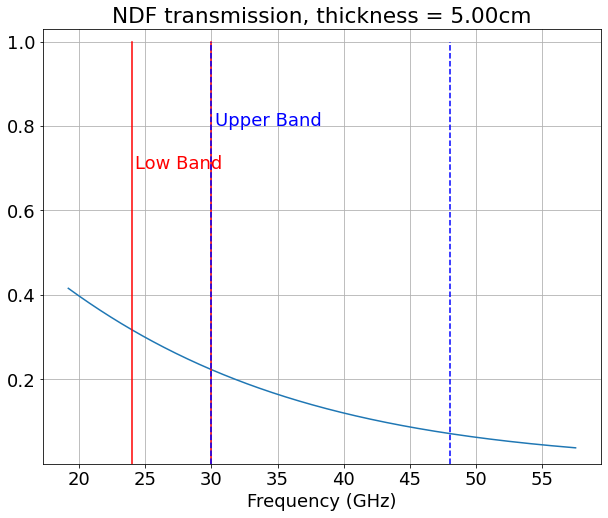

In [26]:
# Plot NDF transmission
miny = 1e-6
maxy = 1
plt.plot(nu,transmission)
plt.plot([LowBand_lowedge,LowBand_lowedge],[miny,maxy],'r')
plt.plot([LowBand_upperedge,LowBand_upperedge],[miny,maxy],'r')
plt.plot([HighBand_lowedge,HighBand_lowedge],[miny,maxy],'--b')
plt.plot([HighBand_upperedge,HighBand_upperedge],[miny,maxy],'--b')
plt.ylim([miny,1.03*maxy])
plt.grid()
plt.title('NDF transmission, thickness = {0:2.2f}cm'.format(d))
plt.xlabel('Frequency (GHz)')
plt.text(LowBand_lowedge*1.01,0.7*maxy,'Low Band',color='red')
plt.text(HighBand_lowedge*1.01,0.8*maxy,'Upper Band',color='blue')

print('Tc_upper = {0:3.2f}K, n = {1:3.2f}'.format(Tc_upper,n))
print('NDF (thickness, temp) = {0:2.2f}cm, {1:2.2f}K'.format(d,T_ndf))
print('Lower Band Loading ('+BL+'GHz)')
print('   Popt on sky        : {0:2.2f} pW'.format(Popt_low))
print('   Popt in lab w/ NDF : {0:2.2f} pW  (needs to be less than next line)'.format(lbl_2*1e12))
print('   Psat, on high-Tc   : {0:2.2f} pW'.format(Psat_low_highTc))
print('')
print('Upper Band Loading ('+BH+'GHz)')
print('   Popt on sky        : {0:2.2f} pW'.format(Popt_high))
print('   Popt in lab w/ NDF : {0:2.2f} pW (needs to be less than next line)'.format(hbl_2*1e12))
print('   Psat, on high-Tc   : {0:2.2f} pW'.format(Psat_high_highTc))


# Denouement
Check whether the results given in the cell above are "okay".  We want "P_opt in lab with NDF" to be less than the upper Tc's Psat, for both bands.  And, we want the plot of NDF transmission to be not "too sloped" across each band, so it is reasonable to deconvolve it for FTS testing.  (The latter is a qualitative rather than quantitative statement.  A factor of 2-3 is probably okay across a given band, but a factor of 10 is probably not.)  The temperature and thickness of the NDF can be adjusted to affect these results - I have roughly tuned them to give reasonable values.